In [358]:
%pylab inline

import urllib2
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
from dateutil.parser import parse
import datetime

Populating the interactive namespace from numpy and matplotlib


# Buncha User Functions to sort out the messy Reddit HTML

In [359]:
def connect(url):
    hackerVoiceImIn = False
    while not hackerVoiceImIn:
        try:
            socket = urllib2.urlopen(url)
            html = socket.read()
            soup = BeautifulSoup(html, 'lxml')
            hackerVoiceImIn = True
        except:
            time.sleep(3)
            pass
    return soup

In [360]:
class CommentBox:
    def __init__(self, soup):
        self.soup = soup
    def get_soup(self):
        return self.soup
    def get_author(self):
        return self.soup.get('data-author')
    def get_neighbors(self):
        result = self.soup.find_next_siblings()[1::2]
        result = map(lambda x: CommentBox(x), result)
        return result
    def get_entry_unvoted(self):
        return self.soup.find('div', {'class':'entry unvoted'})
    def get_child(self):
        return self.soup.find('div', {'class':'child'})
    def get_comment(self):
        return EntryUnvoted(self.get_entry_unvoted()).get_comment()

In [361]:
class EntryUnvoted:
    def __init__(self, soup):
        self.soup = soup
    def get_soup(self):
        return self.soup        
    def get_comment(self):
        return str(self.soup.find('div', {'class':'md'}).get_text())
    def get_parent_comment_box(self):
        return self.soup.find_parent()
    def is_a_bargain(self):
        return (self.get_comment() in bargains)
    def get_score(self):
        score = re.compile(r'(\d+) points')
        text = self.soup.find('span', {'class': 'score likes'}).get_text()
        return int(score.findall(text)[0])
    def get_author(self):
        return CommentBox(self.get_parent_comment_box()).get_author()
    def get_time(self):
        return parse(self.soup.find('time').get('datetime'))
    def get_url(self):
        return self.soup.find('ul').find('a').get('href')

In [362]:
class Child:
    def __init__(self, soup):
        self.soup = soup
    def get_soup(self):
        return self.soup 
    def get_comment_boxes(self):
        base = CommentBox(self.soup.find('div').find('div'))
        #print base.get_neighbors()
        result = [base]
        result.extend(base.get_neighbors())
        return result

In [353]:
url = r'https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kwuke/'
soup = connect(url)
e = EntryUnvoted(soup.findAll('div', {'class': 'entry unvoted'})[1])
e.get_url()

'https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kwuke/'

# The comments strings that we're after

In [363]:
bargains = ('"Dormammu, I\'ve come to bargain"\n', '"Dormammu, I\'ve come to bargain."\n')

# Want to get FilmsAreQuiteAwesome's first comment. This is our Base Case.

In [364]:
url = r'https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kwuke/'

In [365]:
authors = ['FilmsAreQuiteAwesome']
scores = [1065]
otherComments = [0]
pages = [1]
times = [datetime.datetime(2016, 11, 4, 1, 58, 24)]
urls = [url]

In [366]:
def getBoxes(url):
    soup = connect(url)
    base = soup.findAll('div', {'class': 'entry unvoted'})[1]
    eu = EntryUnvoted(base)
    cb = CommentBox(eu.get_parent_comment_box())
    child = Child(cb.get_child())
    boxes = child.get_comment_boxes()
    nextrun = boxes
    return nextrun

In [367]:
def theLoop(nextrun):
    global authors
    global scores
    global otherComments
    global pages
    global times
    global urls
    
    base = nextrun[0]
    author = base.get_author()
    score = EntryUnvoted(base.get_entry_unvoted()).get_score()
    time = EntryUnvoted(base.get_entry_unvoted()).get_time()
    itemUrl = EntryUnvoted(base.get_entry_unvoted()).get_url()
    boxes = Child(base.get_child()).get_comment_boxes()
    nextrun = []
    neighbors = 0
    page = pages[-1]
    for box in boxes:
        try:
            neighbors += 1            
            entry = EntryUnvoted(box.get_entry_unvoted())
            if entry.is_a_bargain():
                nextrun.append(box)
        except:
            url = r'https://www.reddit.com' + entry.get_soup().find('a').get('href')
            pages.append(pages[-1]+1)     
            nextrun = getBoxes(url)
            authors.append(author)
            scores.append(score)
            pages.append(page+1)
            times.append(time)
            urls.append(itemUrl)
            otherComments.append(neighbors)            
            return theLoop(nextrun)
    try:
        authors.append(author)
        scores.append(score)
        pages.append(page)
        times.append(time)
        urls.append(itemUrl)
        otherComments.append(neighbors)
        return theLoop(nextrun)
    except:
        print "Done"

In [368]:
theLoop(getBoxes(url))

Done


# Build out the dataframe for the analysis

In [369]:
data = zip(authors, scores, otherComments, pages, times, urls)
df = pd.DataFrame(data, columns=['Author', 'Score', 'Neighbors', 'Page', 'PostTime', 'URL'])
df['Diff'] = df.PostTime.diff()

# Playground for the material

In [319]:
df.Author.value_counts()

ggalaximm               185
antnylopz                32
gggalaximmm               3
rohay                     1
Torpid-O                  1
Deliwoot                  1
LegitTURDle               1
Kunfuxu                   1
slothalot                 1
SavioVegaGuy              1
DJ-Tom-3                  1
UltraDangerLord           1
Deofol7                   1
MichaelM_Yaa              1
MMX2                      1
themexiwhite              1
kinkosmyers               1
MatsFan5ever              1
JimboJimboSlicee          1
Brady_Hokes_Headset       1
ArcturusFlyer             1
FilmsAreQuiteAwesome      1
Annoying_this_guy         1
Trionout                  1
Velorium_Camper           1
DeoGame                   1
pacmain1                  1
1337speak                 1
wwoofless                 1
Hansmonky                 1
Brolom                    1
nanoman92                 1
Name: Author, dtype: int64

(-1, 1150)

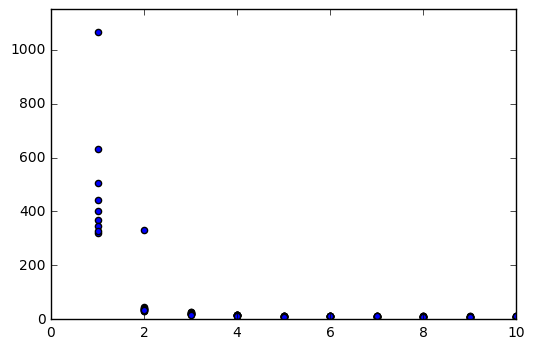

In [326]:
plt.scatter(df.Page, df.Score)
plt.xlim(0, 10)
plt.ylim(-1, 1150)

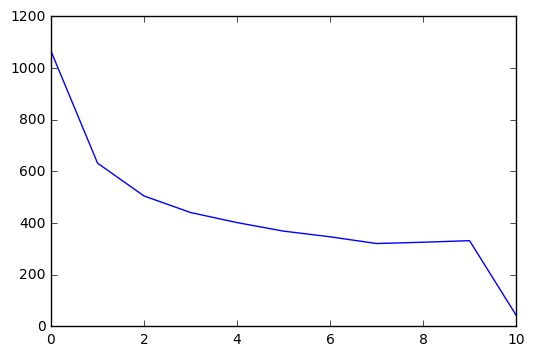

In [321]:
plt.plot(df.Score.loc[:10])

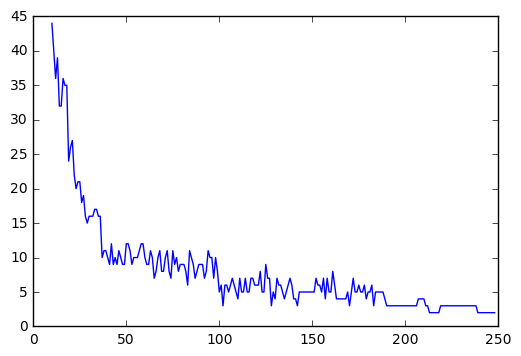

In [322]:
plt.plot(df.Score.loc[10:])


In [382]:
responses = df[(df['Page']> 1) & (df['Neighbors'] > 1)]
responses

,Author,Score,Neighbors,Page,PostTime,URL,Diff
10,UltraDangerLord,44,3,2,2016-11-04 02:57:58+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:07:48
11,Velorium_Camper,36,2,2,2016-11-04 03:02:35+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:04:37
12,Brolom,38,2,2,2016-11-04 03:36:42+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:34:07
13,kinkosmyers,36,2,2,2016-11-04 03:48:49+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:12:07
14,pacmain1,35,2,2,2016-11-04 04:05:32+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:16:43
15,themexiwhite,33,2,2,2016-11-04 04:11:55+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:06:23
16,Brady_Hokes_Headset,34,2,2,2016-11-04 04:21:17+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:09:22
17,MMX2,32,2,2,2016-11-04 04:33:45+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:12:28
21,LegitTURDle,26,2,3,2016-11-04 05:11:15+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:41
152,ggalaximm,5,2,16,2016-11-04 11:05:16+00:00,https://www.reddit.com/r/movies/comments/5b0zn...,00:00:03


In [383]:
for i in responses.index:
    print responses.loc[i, 'URL']

https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kzed7/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9kzll8/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l0zho/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l1gmw/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l248y/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l2cui/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l2oy4/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l349c/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers/d9l4bcn/
https://www.reddit.com/r/movies/comments/5b0zni/official_discussion_doctor_strange_spoilers